In [2]:
# from autoviz.AutoViz_Class import AutoViz_Class
# AV = AutoViz_Class()

import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 100

targhe = [
"FY293YC", "FY295YC", "FY298YC", "FY294YC", "FY296YC", "FV903SK", "FV904SK", "FV906SK", "FV907SK", "FV908SK", "FZ330SC", "FV913SK", "FV914SK", "FY402YC", "FY403YC", "ZB477AN", "ZB473AN", "ZB474AN", "ZB476AN", "ZB475AN", "ZB478AN", "ZB137AR", "ZB139AR", "ZB150AR", "ZB127AR", "ZB132AR", "ZB128AR", "ZB131AR", "ZB130AR", "FY400YC", "ZB135AR", "ZB136AR", "ZB134AR", "ZB373AN", "FY401YC", "CW363HC", "CW367HC", "FP698BP", "FP699BP", "CW365HC", "CW368HC", "CN433CA", "FV989FV", "FV990FV", "FV991FV", "FV995FV", "FV996FV", "FV997FV", "FV992FV", "FV985FV", "FV987FV", "FV988FV", "FV993FV", "FV994FV", "EG181YE", "FV986FV", "EN971TN", "FY299YC", 
]
sns.set_style("whitegrid")

%matplotlib inline

In [3]:
veicoli = pd.read_excel("excels/SEA_Flotta_Elenco_Veicoli.xlsx", skiprows=lambda x: x > 341) # il file contiene altre cose dopo
veicoli = veicoli.drop(veicoli.columns[-5:-2], axis=1)[veicoli.TARGA.isin(targhe)]\
          .reset_index(drop=True).rename(columns=str.title).rename(columns=str.strip)
veicoli["plate"] = veicoli.Targa

veicoli["Sistema Gps Tracking"] = veicoli["Sistema Gps Tracking"].str.replace(' ', '').str.split('+')#.unique()
veicoli = veicoli.explode("Sistema Gps Tracking").groupby(['Targa', 'Sistema Gps Tracking']).first()

fatture = pd.read_excel("excels/eventi_manutenzioni_esterne (da fatture).xlsx")
fatture.Apertura_commessa = pd.to_datetime(fatture.Apertura_commessa)

# Data cleaning - [VISIRUN](https://jupyter.polito.it/expert/hub/user-redirect/lab/tree/ai4Trucks/SEA%20Data%20Lake/VISIRUN)

In [4]:
!du -sh dataset/VISI*

309K	dataset/VISIONLINK_Location.csv
25M	dataset/VISIRUN_CurrentPosition.csv
8.5K	dataset/VISIRUN_FleetOdometerOld.csv
846M	dataset/VISIRUN_RawTrackingData.csv
509M	dataset/VISIRUN_Route.csv


In [132]:
df_VIS_vehicles = pd.read_csv("dataset/VISIRUN_CurrentPosition.csv", index_col=0)
df_VIS_vehicles = df_VIS_vehicles[df_VIS_vehicles.vehiclePlate.isin(targhe)].reset_index(drop=True)
# df_VIS_vehicles.datestamp = pd.to_datetime(df_VIS_vehicles.datestamp, format="%Y-%m-%dT%H:%M:%S")
time_cols = [c for c in df_VIS_vehicles.columns if "date" in c.lower()]
for c in time_cols:
    df_VIS_vehicles[c] = pd.to_datetime(df_VIS_vehicles[c], errors='coerce')
# df_VIS_vehicles.lastCommunicationDatetime = pd.to_datetime(df_VIS_vehicles.lastCommunicationDatetime)

# df_VIS_vehicles.head()

In [133]:
df_VIS_vehicles.head()

,remoteUnitSerial,vehicleName,vehiclePlate,datestamp,vehicleCategory,timezone,lat,lon,workMinutes,statusCode,key,lastCommunicationDatetime,speed,odometer,heading,filename
0,60009121,CN433CA PIAGGIO,CN433CA,2021-04-27 08:56:56,Raimondi,Europe/Rome,44.699753,8.016591,132346.0,0.0,0.0,2021-04-27 08:56:56,0.0,74059763.0,67.03,2021-04-27-07
1,60013442,CW365HC,CW365HC,2021-04-22 12:23:42,Cantiere La Spezia,Europe/Rome,45.960865,8.420048,188839.0,0.0,0.0,2021-04-25 12:04:12,0.0,25343610.0,231.28,2021-04-27-07
2,60013445,CW368HC,CW368HC,2021-04-27 07:32:19,Cantiere La Spezia,Europe/Rome,45.716534,10.093649,160000.0,0.0,0.0,2021-04-27 08:37:55,0.0,23440240.0,127.25,2021-04-27-07
3,60009121,CN433CA PIAGGIO,CN433CA,2021-04-27 10:01:28,Raimondi,Europe/Rome,44.678673,7.987436,132346.0,0.0,1.0,2021-04-27 10:01:28,33.4,74068039.0,58.04,2021-04-27-08
4,60013442,CW365HC,CW365HC,2021-04-22 12:23:42,Cantiere La Spezia,Europe/Rome,45.960865,8.420048,188839.0,0.0,0.0,2021-04-25 12:04:12,0.0,25343610.0,231.28,2021-04-27-08


---
## Overview

In [160]:
date_range = (df_VIS_vehicles.datestamp.dt.date.max() - df_VIS_vehicles[df_VIS_vehicles.datestamp.dt.year==2021].datestamp.dt.date.min()).days
targhe_here = df_VIS_vehicles.vehiclePlate.unique()

print(f"Dati raccolti tra {df_VIS_vehicles[df_VIS_vehicles.datestamp.dt.year==2021].datestamp.dt.date.min().strftime('%m/%Y')} e {df_VIS_vehicles.datestamp.dt.date.max().strftime('%m/%Y')}\n\
{df_VIS_vehicles.shape[1]} parametri totali monitorati\n\
{df_VIS_vehicles.shape[0]} record nel datalake\n\
{df_VIS_vehicles.drop(['filename', 'lastCommunicationDatetime'], axis=1).drop_duplicates().shape[0]} record non ripetuti\n\
{len(targhe_here)} truck monitorati\n\
In media {df_VIS_vehicles.shape[0]/len(targhe_here):.5} misurazioni per ogni mezzo su 5 mesi\n\
In media {df_VIS_vehicles.shape[0]/len(targhe_here)/date_range:.3} misurazioni/giorno/mezzo (dettaglio successivamente)\n\
{len(fatture[(fatture.Targa.isin(df_VIS_vehicles.vehiclePlate.unique()))&(fatture.Apertura_commessa>'2021-05-01')])} fatture associate.")

Dati raccolti tra 04/2021 e 09/2021
15 parametri totali monitorati
20990 record nel datalake
6121 record non ripetuti
12 truck monitorati
In media 1749.2 misurazioni per ogni mezzo su 5 mesi
In media 11.4 misurazioni/giorno/mezzo (dettaglio successivamente)
14 fatture associate.


In [136]:
useless_cols = [c for c in df_VIS_vehicles.columns if len(df_VIS_vehicles[c].unique()) == 1]
print(df_VIS_vehicles[useless_cols].iloc[0,:])

df_VIS_vehicles = df_VIS_vehicles.drop(useless_cols, axis=1)

timezone      Europe/Rome
statusCode            0.0
Name: 0, dtype: object


In [140]:
report = df_VIS_vehicles[df_VIS_vehicles.datestamp.dt.year == 2021].groupby('vehiclePlate').agg({
    "datestamp": ["min", "max", "count", pd.Series.nunique],
}).droplevel(0, axis=1)

report["fatture"] = report.apply(lambda x: fatture[(fatture.Targa==x.name)&(fatture.Apertura_commessa.dt.date>=x['min'].date())&(fatture.Apertura_commessa.dt.date<=x['max'].date())].ID.count(), axis=1)
report = report.reset_index().rename(columns={
    'count': 'n_samples',
    'nunique': 'distinct',
})

In [141]:
report.head()

,vehiclePlate,min,max,n_samples,distinct,fatture
0,CN433CA,2021-04-27 08:56:56,2021-09-21 18:30:28,1783,375,0
1,CW365HC,2021-04-22 12:23:42,2021-09-11 07:03:20,1783,119,1
2,CW368HC,2021-04-27 07:32:19,2021-09-21 12:50:53,1780,600,0
3,FP698BP,2021-04-27 10:56:14,2021-09-22 14:32:54,1764,931,2
4,FP699BP,2021-04-27 11:06:33,2021-09-22 02:22:47,1770,759,2


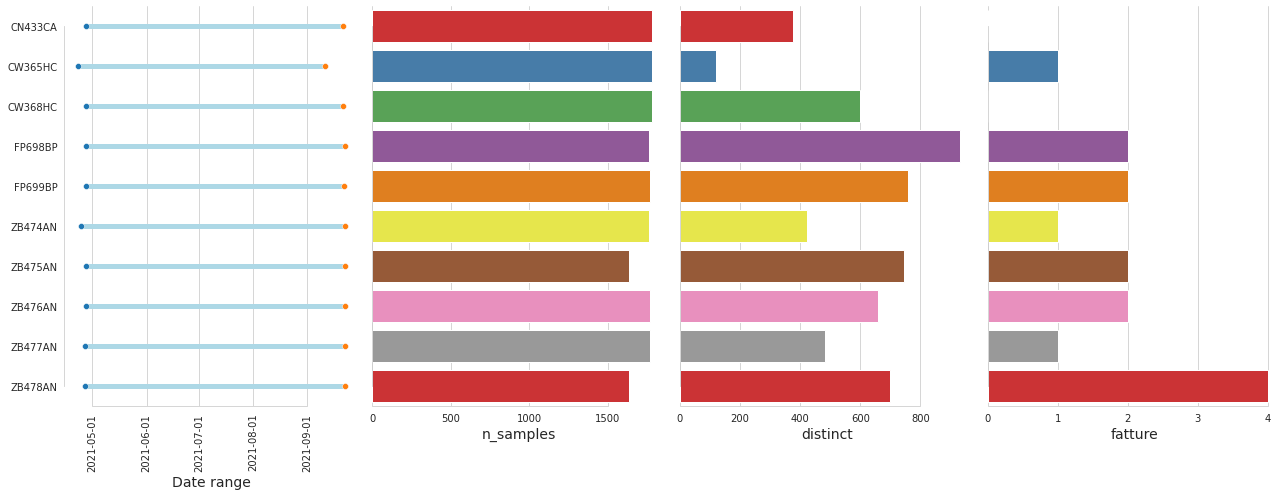

In [142]:
fig, ax = plt.subplots(1,4, figsize=(18,7), sharey=True)
sns.scatterplot(data=report, x="min", y="vehiclePlate", palette='Set1', ax=ax[0], zorder=4)
sns.scatterplot(data=report, x="max", y="vehiclePlate", palette='Set1', ax=ax[0], zorder=4)
ax[0].hlines(data=report, y="vehiclePlate", xmin="min", xmax="max", linewidth=5, color='lightblue')
sns.barplot(data=report, x="n_samples", y="vehiclePlate", palette='Set1', ax=ax[1])
sns.barplot(data=report, x="distinct", y="vehiclePlate", palette='Set1', ax=ax[2])
sns.barplot(data=report, x="fatture", y="vehiclePlate", palette='Set1', ax=ax[3])

ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xlabel("Date range")
for a in ax:
    a.set_ylabel("")
    a.set_xlabel(a.get_xlabel(), size=14)
#     a.grid(False)
    a.yaxis.grid(False)
    sns.despine(trim=True)
    
plt.tight_layout()

---
## Analisi Misurazioni giornaliere

In [155]:
tmp = pd.read_csv("dataset/VISIRUN_CurrentPosition.csv", index_col=0)
tmp[tmp.vehiclePlate == "CW367HC"].drop(["filename", "lastCommunicationDatetime"], axis=1).drop_duplicates()

,remoteUnitSerial,vehicleName,vehiclePlate,datestamp,vehicleCategory,timezone,lat,lon,workMinutes,statusCode,key,speed,odometer,heading
69,60013574,CW367HC Porter,CW367HC,2020-12-16T11:31:16,Cantiere La Spezia,Europe/Rome,45.237946,7.557693,201223.0,0.0,0.0,1.9,132990590.0,0.0


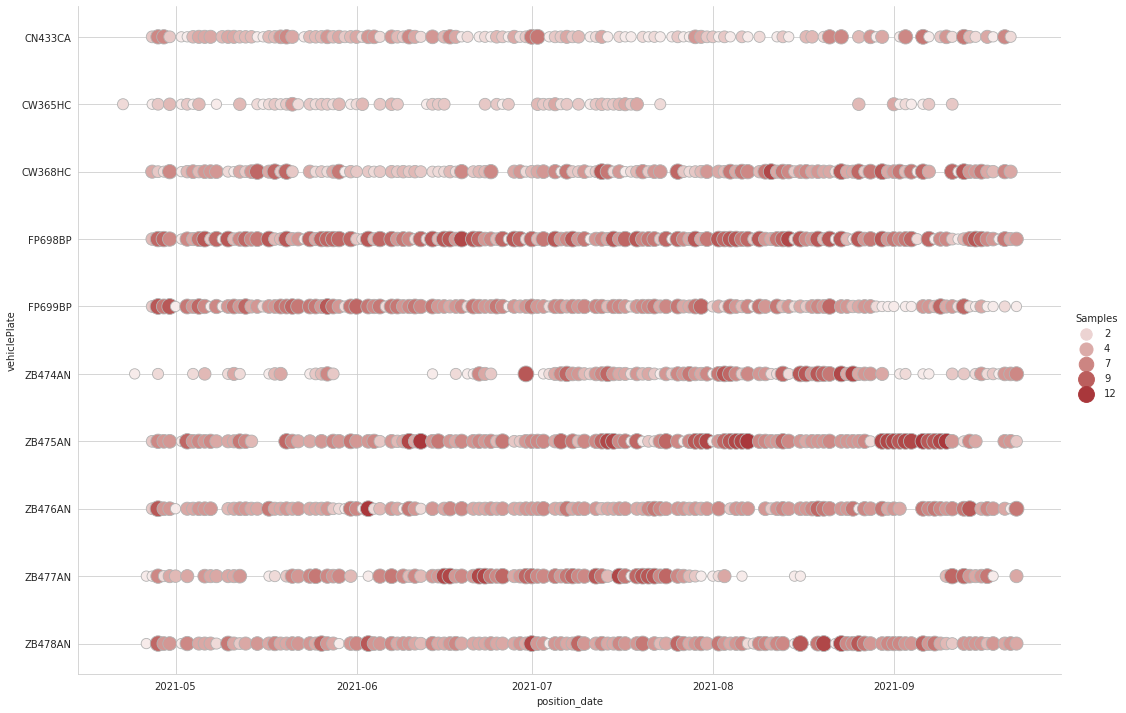

In [158]:
df_VIS_vehicles["position_date"] = df_VIS_vehicles.datestamp.dt.date
tmp = df_VIS_vehicles[df_VIS_vehicles.datestamp.dt.year==2021].drop(["filename", "lastCommunicationDatetime"], axis=1).drop_duplicates().sort_values(by="position_date").groupby(["vehiclePlate", "position_date"], as_index=False).key.count()
tmp['c'] = tmp.key / tmp.key.max()
g = sns.relplot(
    data=tmp,
    x="position_date", y="vehiclePlate", hue="c", size="c",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8), aspect=1.5
)

for t in g._legend.get_texts():
    t.set_text(int(float(t.get_text())*tmp.key.max()))
g._legend.set_title("Samples")

Text(0, 0.5, 'count')

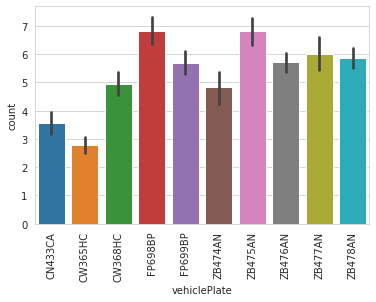

In [161]:
g = sns.barplot(data=tmp, x="vehiclePlate", y="key")
g.tick_params(axis='x', rotation=90)
g.set_ylabel("count")

---
## Monotonia

In [162]:
df_VIS_vehicles = df_VIS_vehicles[df_VIS_vehicles.datestamp.dt.year==2021].drop(["filename", "lastCommunicationDatetime"], axis=1).drop_duplicates()

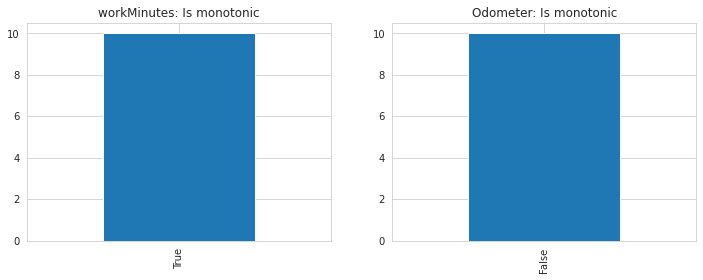

In [163]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
df_VIS_vehicles.groupby('vehiclePlate').workMinutes.apply(lambda x: x.is_monotonic_increasing).value_counts().sort_values(ascending=True).plot(kind="bar", title=f"workMinutes: Is monotonic", ax=ax[0])
df_VIS_vehicles.groupby('vehiclePlate').odometer.apply(lambda x: x.is_monotonic_increasing).value_counts().plot(kind="bar", title="Odometer: Is monotonic", ax=ax[1])
plt.show()

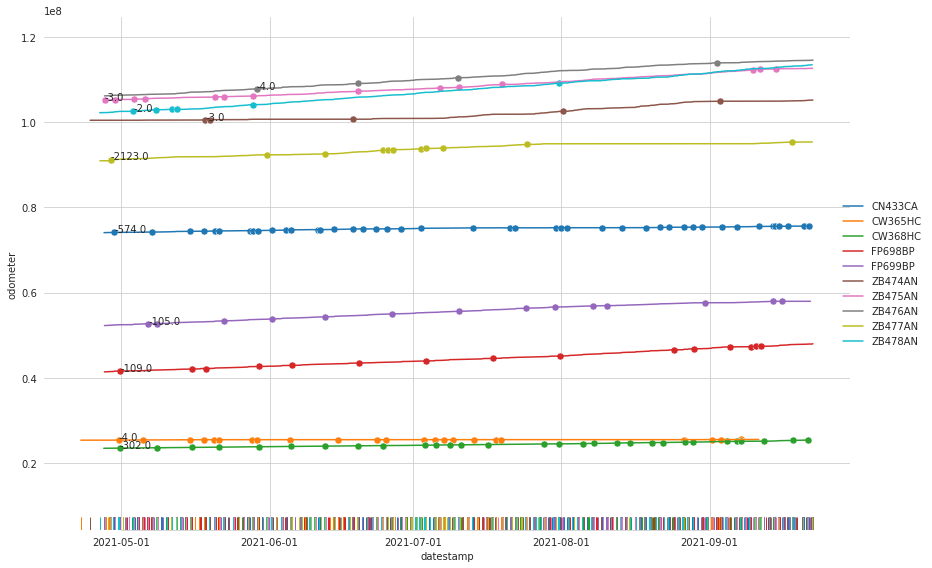

In [170]:
fig, ax = plt.subplots(figsize=(12,8), sharex=True)
# sns.lineplot(data=df_VIS_vehicles, x="datestamp", y="workMinutes", hue="vehiclePlate", ax=ax[0])
# sns.rugplot(data=df_VIS_vehicles, x="datestamp", hue="vehiclePlate", ax=ax[0])

sns.lineplot(data=df_VIS_vehicles, x="datestamp", y="odometer", hue="vehiclePlate", ax=ax)
sns.rugplot(data=df_VIS_vehicles, x="datestamp", hue="vehiclePlate", ax=ax)

for i, (vehiclePlate, d) in enumerate(df_VIS_vehicles.groupby('vehiclePlate')[["datestamp", "odometer"]]):
    d["df"] = d.odometer.diff().fillna(0)
    sns.scatterplot(data=d[d.df<0], x="datestamp", y="odometer", markers="*", s=50)
    plt.text(x=d[d.df<0].datestamp.values[0], y=d[d.df<0].odometer.values[0], s=str(d[d.df<0].df.values[0]))

fig.tight_layout()
# ax[1].get_legend().remove()

sns.despine(trim=True, left=True)
ax.legend(frameon=False, loc="center right", bbox_to_anchor=(1.1,0.5))
plt.show()

In [93]:
df_VIS_vehicles[df_VIS_vehicles.datestamp<"2021-05-01"]

,index,remoteUnitSerial,vehicleName,vehiclePlate,datestamp,vehicleCategory,lat,lon,workMinutes,key,lastCommunicationDatetime,speed,odometer,heading,filename
0,3,60009121,CN433CA PIAGGIO,CN433CA,2021-04-27 08:56:56,Raimondi,44.699753,8.016591,132346.0,0.0,2021-04-27 08:56:56,0.0,74059763.0,67.03,2021-04-27-07
1,6,60013442,CW365HC,CW365HC,2021-04-22 12:23:42,Cantiere La Spezia,45.960865,8.420048,188839.0,0.0,2021-04-25 12:04:12,0.0,25343610.0,231.28,2021-04-27-07
2,7,60013445,CW368HC,CW368HC,2021-04-27 07:32:19,Cantiere La Spezia,45.716534,10.093649,160000.0,0.0,2021-04-27 08:37:55,0.0,23440240.0,127.25,2021-04-27-07
3,29,60009121,CN433CA PIAGGIO,CN433CA,2021-04-27 10:01:28,Raimondi,44.678673,7.987436,132346.0,1.0,2021-04-27 10:01:28,33.4,74068039.0,58.04,2021-04-27-08
4,32,60013442,CW365HC,CW365HC,2021-04-22 12:23:42,Cantiere La Spezia,45.960865,8.420048,188839.0,0.0,2021-04-25 12:04:12,0.0,25343610.0,231.28,2021-04-27-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20960,146185,60025959,ZB473AN Azimut 6,ZB473AN,2020-10-03 03:43:48,Roma,41.958782,12.697359,283825.0,0.0,NaT,0.0,76996710.0,303.33,2021-09-22-12
20968,146212,60013574,CW367HC Porter,CW367HC,2020-12-16 11:31:16,Cantiere La Spezia,45.237946,7.557693,201223.0,0.0,NaT,1.9,132990590.0,0.00,2021-09-22-13
20972,146268,60025959,ZB473AN Azimut 6,ZB473AN,2020-10-03 03:43:48,Roma,41.958782,12.697359,283825.0,0.0,NaT,0.0,76996710.0,303.33,2021-09-22-13
20980,146295,60013574,CW367HC Porter,CW367HC,2020-12-16 11:31:16,Cantiere La Spezia,45.237946,7.557693,201223.0,0.0,NaT,1.9,132990590.0,0.00,2021-09-22-14


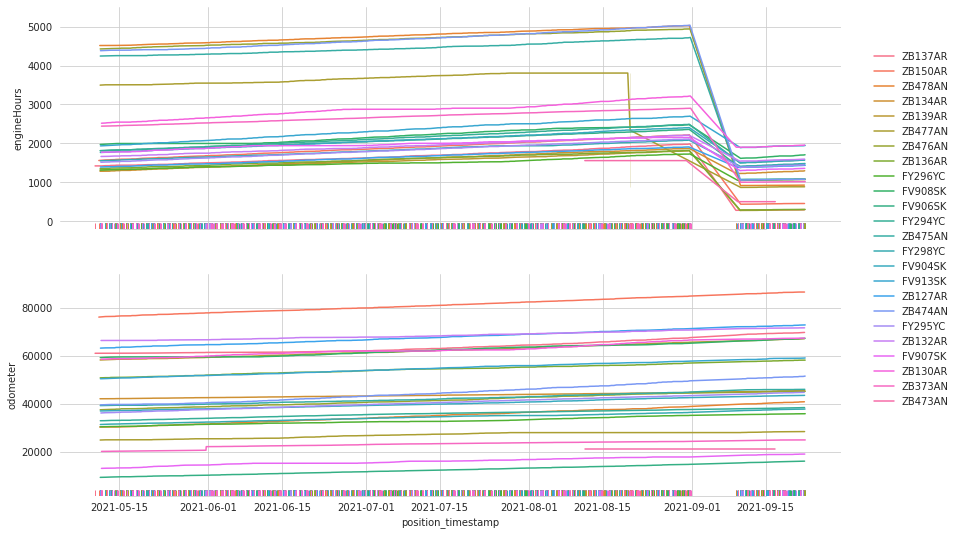

In [166]:
fig, ax = plt.subplots(2,1, figsize=(14,9), sharex=True)
tmp2 = df_VIS_vehicles[(df_VIS_vehicles.groupby('vehiclePlate').engineHours.transform(lambda x: not x.is_monotonic_increasing))&(df_VIS_vehicles.datestamp.dt.year == 2021)]
sns.lineplot(data=tmp2, x="datestamp", y="engineHours", hue="vehiclePlate", ax=ax[0])
sns.rugplot(data=tmp2, x="datestamp", hue="vehiclePlate", ax=ax[0])

ax[0].legend(frameon=False, loc="center right", bbox_to_anchor=(1.15,0))

sns.lineplot(data=tmp2, x="datestamp", y="odometer", hue="vehiclePlate", ax=ax[1])
sns.rugplot(data=tmp2, x="datestamp", hue="vehiclePlate", ax=ax[1])

sns.despine(trim=True, left=True)
ax[1].get_legend().remove()
plt.show()

In [167]:
df_VIS_vehicles[df_VIS_vehicles.datestamp.dt.date<pd.to_datetime("2021-09-01")].groupby('vehiclePlate').engineHours.apply(lambda x: x.is_monotonic_increasing).value_counts().sort_index(ascending=False)#.plot(kind="bar", title="Is monotonic (before 2021-09-01)")
# plt.show()

/home/students/s265780/.local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


True     33
False     2
Name: engineHours, dtype: int64

---
## Correlation

In [176]:
df_VIS_vehicles.head()

,alarm_id,alarm_name,alarm_priority,alarm_tipology_id,box,brand,chassis,engineHours,id,model,name,odometer,plate,position_gps_lat,position_gps_lng,position_id,position_ignition,position_place_address,position_place_placeStr,position_place_state,position_place_zip,position_speed,position_timestamp,position_typology_id,position_typology_label,sav,position_date
119,0,NaN,0,NONE,D4256,Isuzu,TIS283439/18,1559,7417,M21,Isuzu M21,21263,ZB473AN,41.958810,12.697287,799512776,False,Via dei Castagni,Guidonia Montecelio,Lazio,12.0,0,2020-10-03 08:31:04+00:00,communication,Comunicazione,TIS283439/18,2020-10-03
35316,0,NaN,0,NONE,D4256,Isuzu,TIS283439/18,1559,7417,M21,Isuzu M21,21263,ZB473AN,41.958810,12.697287,799512776,False,Via dei Castagni,Guidonia Montecelio,Lazio,12.0,0,2020-10-03 08:31:04+00:00,communication,Comunicazione,TIS283439/18,2020-10-03
63045,0,NaN,0,NONE,D6258,Isuzu,TIS433608/18,1423,10297,M21,Isuzu M21,61051,ZB137AR,45.888203,8.525465,1060364362,False,Via Sempione Nord,Stresa,Piemonte,28838.0,0,2021-05-10 10:07:06+00:00,digital_input_change,Cambio Digital IN,TIS433608/18,2021-05-10
35269,0,NaN,0,NONE,D6181,Isuzu,TIS433605/18,1562,10267,M21,Isuzu M21,76114,ZB150AR,45.960815,8.420044,1060599894,True,Via Pra' del Fico 2,Ornavasso,Piemonte,28877.0,0,2021-05-11 03:12:11+00:00,digital_input_change,Cambio Digital IN,TIS433605/18,2021-05-11
35272,0,NaN,0,NONE,D4289,Isuzu,TIS083876/19,1465,9633,P75,Isuzu P75,27374,FY403YC,45.907375,10.840083,1060817768,False,Via Nuova 7,Riva del Garda,Trentino-Alto Adige,38066.0,1,2021-05-11 06:58:25+00:00,motion_stop,Fine movimento,TIS083876/19,2021-05-11


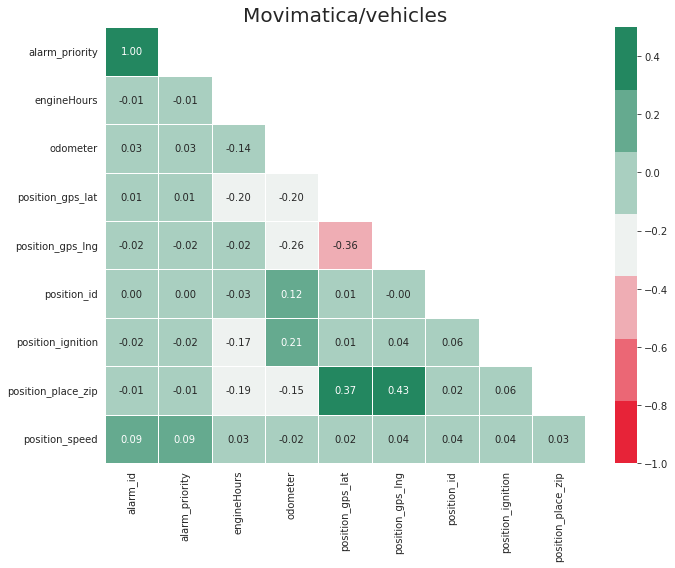

In [177]:
pseudo_plate = [c for c in df_VIS_vehicles.columns if len(df_VIS_vehicles[c].unique()) == 35]
correlations = df_VIS_vehicles.drop(pseudo_plate, axis=1).corr()

fig, ax = plt.subplots(figsize=(10,8))
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
heatmap = sns.heatmap(correlations.iloc[1:,:-1], annot=True, fmt='.2f', linewidths=0.5,
            mask=mask[1:,:-1], ax=ax, cmap=sns.diverging_palette(10, 150, s=90, n=7),
            robust=True, vmin=-1)#, annot_kws={"size": 10})
plt.title("Movimatica/vehicles", size=20)
plt.tight_layout()
# fig.savefig("corr.png")

In [178]:
df_VIS_vehicles[['alarm_id', 'alarm_priority', 'alarm_name', 'alarm_tipology_id']].drop_duplicates()

,alarm_id,alarm_priority,alarm_name,alarm_tipology_id
119,0,0,NaN,NONE
5502,1861321,4,Alert Alternatore,ANOMALY
96328,1825143,4,Alert Alternatore,ANOMALY
72828,1665634,4,Alert Alternatore,ANOMALY
4719,1830776,4,Alert Alternatore,ANOMALY
18332,1862428,4,Alert Alternatore,ANOMALY
75003,1790271,4,Alert Alternatore,ANOMALY
64314,1863512,4,Alert Alternatore,ANOMALY
36357,1665633,4,Alert Alternatore,ANOMALY


---
## PCA

In [179]:
data_std.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')]).index

Index(['odometer', 'engineHours', 'position_speed', 'position_ignition'], dtype='object')

In [180]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# numerical_cols = df_VIS_vehicles.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')])
# numerical_cols = df_VIS_vehicles.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')])
# data_std = df_VIS_vehicles[numerical_cols[numerical_cols].index].drop(["id", "alarm_id"], axis=1)
data_std = df_VIS_vehicles[["odometer", "engineHours", "position_speed", "position_ignition"]].copy()

data_std[data_std.columns] = StandardScaler().fit_transform(data_std[data_std.columns])
data_std.head()

,odometer,engineHours,position_speed,position_ignition
119,-1.306122,-0.714378,-0.293483,-0.827088
35316,-1.306122,-0.714378,-0.293483,-0.827088
63045,0.927527,-0.852566,-0.293483,-0.827088
35269,1.773145,-0.711330,-0.293483,1.209062
35272,-0.963058,-0.809890,-0.151331,-0.827088


In [182]:
data_std = data_std.dropna()
pca = PCA(n_components=4)
pca.fit(data_std)
projection = pca.transform(data_std)

In [183]:
var_ratio = pca.explained_variance_ratio_
var_ratio

array([0.33576503, 0.25413525, 0.21557315, 0.19452656])

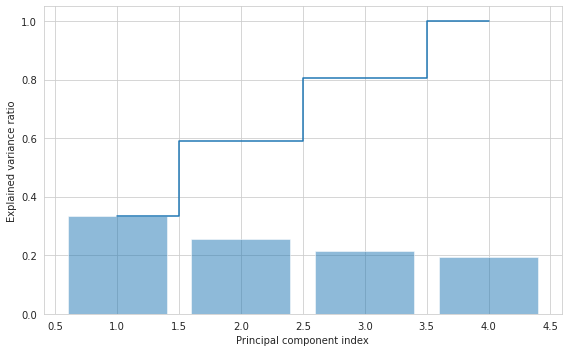

In [184]:
cum_sum_eigenvalues = np.cumsum(var_ratio)
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(var_ratio) + 1), var_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(var_ratio) + 1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
#plt.legend(loc='best')
plt.tight_layout()
# plt.savefig("PCA_6")
plt.show()

In [165]:
most_important = [np.argpartition(np.abs(pca.components_[i]), -3)[-3:] for i in range(len(var_ratio))]

In [167]:
initial_feature_names = data_std.columns
most_important_names = {i: initial_feature_names[most_important[i]].to_list() for i in range(len(var_ratio))}

In [168]:
most_important_names

{0: ['odometer', 'position_place_zip', 'position_gps_lng'],
 1: ['position_gps_lng', 'engineHours', 'position_gps_lat'],
 2: ['position_gps_lng', 'position_ignition', 'position_gps_lat'],
 3: ['position_id', 'alarm_priority', 'position_speed'],
 4: ['engineHours', 'alarm_priority', 'position_id'],
 5: ['position_ignition', 'alarm_priority', 'position_speed']}

**position_place_zip??**

In [134]:
pd.read_csv("dataset/VISIRUN_FleetOdometerOld.csv")

,Unnamed: 0,remoteUnitSerial,vehicleName,plate,odometer,engineOnTime
0,0,60039415,GC554HZ,GC554HZ,166899.1,18031:24
1,1,60039226,VISIRUN BOX 8,GDT00380,N.A.,N.A.
2,2,60013499,EV166DN,EV166DN,127606.42,15758:54
3,3,60013442,CW365HC,CW365HC,25376.17,3149:03
4,4,60013596,CX199WX,CX199WX,368722.54,2827:53
...,...,...,...,...,...,...
121,121,60013495,EV160DN,EV160DN,170225.6,16559:30
122,122,60002941,EV165DN EUROCARGO160,EV165DN,121596.24,18747:12
123,123,60025921,DR766RE VOLVO,DR766RE,543911.48,15946:36
124,124,60039249,ZB131AR,ZB131AR,55505.83,1891:52


In [196]:
df_dipendenti = pd.read_csv("dataset/DIPENDENTI_DipendentiList.csv", index_col=0).drop_duplicates()

In [215]:
df_dipendenti[['Nome', 'Cognome']].drop_duplicates()

,Nome,Cognome
0,CORNELIU,ADONICIOAE
1,PAVEL PETRONEL,ANDRISOAIA
2,SIMONA,AGNELLO
3,ROBERTO,AGOSTINI
4,ROBERTO,AGUELI
...,...,...
583,ALESSIO ANTONIO,PEZZOLATO
584,STEFANO,SGARAMELLA
585,DANIEL,PASQUARIELLO
586,NADIR,BOSSI


In [214]:
df_dipendenti.groupby([['Nome', 'Cognome']])#.idUtente#.transform('count')

ValueError: Grouper and axis must be same length

In [207]:
len(pd.read_csv("dataset/DIPENDENTI_DipendentiList.csv", index_col=0))/13

587.6153846153846